In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [32]:
help(tickerData.history)

Help on method history in module yfinance.base:

history(period='1mo', interval='1d', start=None, end=None, prepost=False, actions=True, auto_adjust=True, back_adjust=False, repair=False, keepna=False, proxy=None, rounding=False, timeout=10, debug=True, raise_errors=False) -> pandas.core.frame.DataFrame method of yfinance.ticker.Ticker instance
    :Parameters:
        period : str
            Valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
            Either Use period parameter or use start and end
        interval : str
            Valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
            Intraday data cannot extend last 60 days
        start: str
            Download start date string (YYYY-MM-DD) or _datetime, inclusive.
            Default is 1900-01-01
            E.g. for start="2020-01-01", the first data point will be on "2020-01-01"
        end: str
            Download end date string (YYYY-MM-DD) or _datetime, exclusive.
            Default is now
  

In [54]:
import yfinance as yf

tickerSymbol = 'GOOGL'
tickerData = yf.Ticker(tickerSymbol)
tickerDf = tickerData.history(period='max', interval='1d', start='2000-1-1', end='2020-1-25')
tickerDf

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2004-08-19 00:00:00-04:00,2.502503,2.604104,2.401401,2.511011,893181924,0.0,0.0
2004-08-20 00:00:00-04:00,2.527778,2.729730,2.515015,2.710460,456686856,0.0,0.0
2004-08-23 00:00:00-04:00,2.771522,2.839840,2.728979,2.737738,365122512,0.0,0.0
2004-08-24 00:00:00-04:00,2.783784,2.792793,2.591842,2.624374,304946748,0.0,0.0
2004-08-25 00:00:00-04:00,2.626627,2.702703,2.599600,2.652653,183772044,0.0,0.0
...,...,...,...,...,...,...,...
2020-01-17 00:00:00-05:00,73.126999,74.027496,72.827499,73.975998,52424000,0.0,0.0
2020-01-21 00:00:00-05:00,73.949997,74.494003,73.510498,74.112503,48930000,0.0,0.0
2020-01-22 00:00:00-05:00,74.486504,75.028999,74.133003,74.193497,28458000,0.0,0.0


In [83]:
open_prices = tickerDf['open'].to_numpy()
plt.plot(range(len(open_prices)), open_prices)

KeyError: ignored

As we can see, this graph looks like a exponential graph, however fourier transform performs the best if the graph looks more like a wave

Reducing the exponential nature of the graph

In [84]:
import math
open_prices_stationary = tickerDf['Open'].apply(math.log, args = [math.e]).to_numpy()

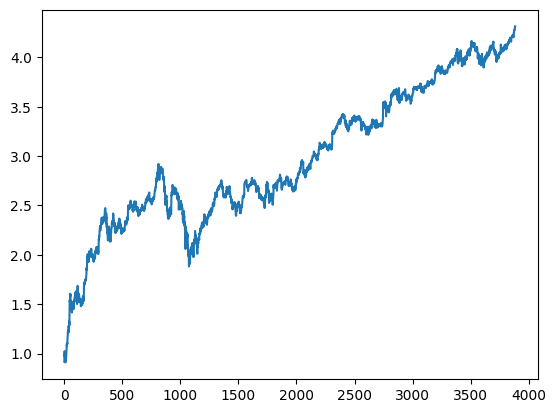

In [85]:
plt.plot(range(len(open_prices_stationary)), open_prices_stationary)

Now the graph looks more linear. However the graph contains a slope which can still make the lower y values infinitesimal once the normalization is performed. So It is better to fit a straight line over the data and normalize the data

In [86]:
from sklearn.linear_model import LinearRegression
linear_reg = LinearRegression()
linear_reg.fit(np.array(range(len(open_prices_stationary))).reshape(-1,1),open_prices_stationary)
y1,y2 = linear_reg.predict([[0],[3000]])

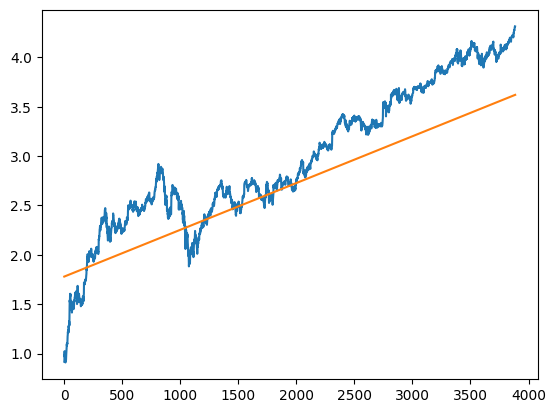

In [87]:
plt.plot(range(len(open_prices_stationary)), open_prices_stationary)
plt.plot([0,len(open_prices_stationary)],[y1,y2])

Calculating m and c of fitted line

In [88]:
#c will be the value of y when x = 0
c = linear_reg.predict([[0]])[0]
c

1.779324329823931

In [89]:
#if x = 1, y = m+c, Therefore m = y(1)-c

m = linear_reg.predict([[1]])[0] - c
m

0.0006135863607652503

In [90]:
# Now the equation has become mx-y+c = 0, perpendicular distances between a point and a line is (mx-y+c)/(m*m+1)
perp_distances = (m*np.array(range(len(open_prices_stationary))) - open_prices_stationary + c)/(m*m+1)

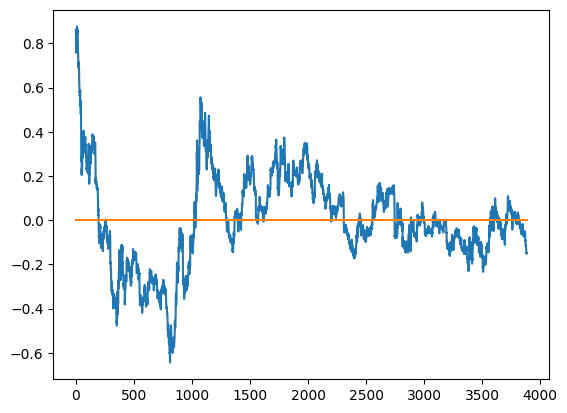

In [91]:
plt.plot(range(len(perp_distances)), perp_distances)
plt.plot([0,len(perp_distances)],[0,0])

Applying fourier transform

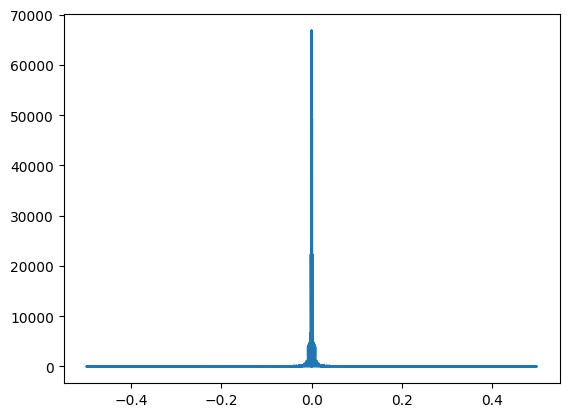

In [92]:
# Apply Fourier Transform
freqs = np.fft.fftfreq(len(perp_distances))
fft = np.fft.fft(perp_distances)

# Get the power spectrum
psd = np.abs(fft) ** 2

# Plot the results
import matplotlib.pyplot as plt

plt.plot(freqs, psd)
plt.show()

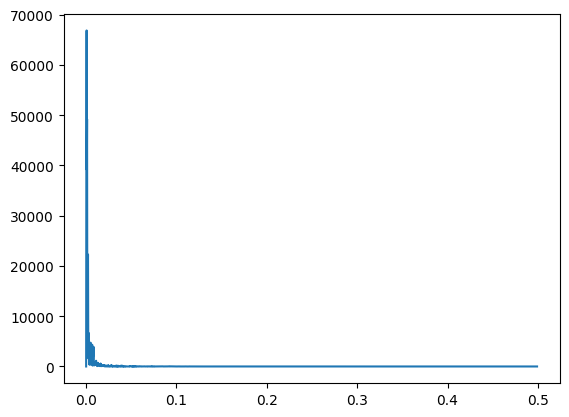

In [93]:
plt.plot(freqs[:1940], psd[:1940])

Finding a threshold

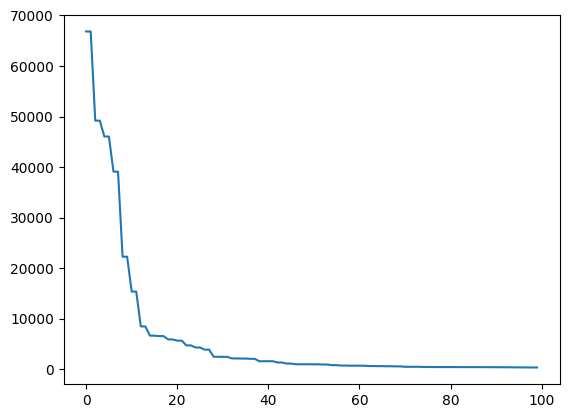

In [94]:
plt.plot(range(100), sorted(psd, reverse = True)[:100])

We can see an elbow at 15 which is approx 6000 on y

In [95]:
(psd>6000).sum()

18

In [96]:
freqs[psd>6000]*len(perp_distances)

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,  11., -11.,  -8.,
        -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.])

Now that we have found the most impactful frequencies, we can now split the data into intervals of thsese frequencies

In [103]:
freq = 11

In [105]:
def create_dataset(open_prices, f):
  dataset = [[j for j in open_prices[i:i+f]] for i in range(len(open_prices - f)) ]
  X = dataset[:-1]
  y = dataset[1:]
  return X, y 

X,y = create_dataset(open_prices, freq)

In [106]:
len(X)

3884

In [107]:
train_size = 3000
train_x, train_y = X[:train_size], y[:train_size]
test_x, test_y = X[train_size:], y[train_size:]

In [109]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(freq, 1)))
model.add(Dense(units=freq))

In [110]:

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(train_x, train_y, epochs=100, batch_size=32)

Epoch 1/100


InvalidArgumentError: ignored